# Burger Equation

1D Burger Equation is defined as:

$$
\begin{align}
u_t + uu_x &= \mu u_{xx}, x \in \left [ -1, 1 \right ], t > 0 \\
u(x, 0) &= -sin(\pi x) \\
u(-1, t) &= u(1, t) = 0
\end{align}
$$

and $ \mu = 0.01 / \pi $

In [1]:
# import necessary python modules
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# define nn
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, inputs):
        x = torch.tanh(self.fc1(inputs))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# define loss function

mse_loss = nn.MSELoss()

# gradient
def gradient(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
    else:
        return gradient(gradient(u, x), x, order-1)

def loss_pde(model, n, device):
    """
    
    """
    x = torch.linspace(-1, 1, n, requires_grad=True, device=device)
    t = torch.linspace(0, 1, n, requires_grad=True, device=device)

    xm, tm = torch.meshgrid(x, t)
    xm = xm.reshape(-1, 1) # xm.requires_grad = True
    tm = tm.reshape(-1, 1) # tm.requires_grad = True

    xt = torch.concat([xm, tm], dim = 1)
    u = model(xt)

    mu = 0.01 / torch.pi

    pde = gradient(u, t, 1) + u * gradient(u, x, 1) - mu * gradient(u, x, 2)

    cond = torch.zeros_like(u, requires_grad=True, device=device)
    cond = cond.reshape(-1, 1)
    
    return mse_loss(pde, cond)


def loss_bc1(model, n, device):
    """
    
    """

    x = torch.randn(n, 1, requires_grad=True).to(device=device) * 2.0 - 1.0
    t = torch.zeros_like(x, requires_grad=True).to(device=device)

    u = model(torch.concat([x, t], dim = 1))
    cond = -torch.sin(torch.pi * x)

    return mse_loss(u, cond)

def loss_bc2(model, n, device):
    """
    
    """

    t = torch.randn(n, 1, requires_grad=True).to(device=device)
    x = -torch.ones_like(t, requires_grad=True).to(device=device)

    u = model(torch.concat([x, t], dim = 1))
    cond = torch.zeros_like(t)

    return mse_loss(u, cond)

def loss_bc3(model, n, device):
    """
    
    """

    t = torch.randn(n, 1, requires_grad=True).to(device=device)
    x = torch.ones_like(t, requires_grad=True).to(device=device)

    u = model(torch.concat([x, t], dim = 1))
    cond = torch.zeros_like(t)

    return mse_loss(u, cond)

In [4]:
# set training parameters
num_epochs = 10000
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# record loss
loss_list = []
best_loss = 1.0E10

# start training
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    loss = loss_pde(model, 100, device) + \
           loss_bc1(model, 100, device) + \
           loss_bc2(model, 100, device) + \
           loss_bc3(model, 100, device)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    # save model
    loss_list.append(loss.item()) # record loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "./assets/01_Burger_equation_1D_best.pth")


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 18.506742477416992
Epoch 100, Loss: 0.5739189982414246
Epoch 200, Loss: 0.5815269947052002
Epoch 300, Loss: 0.5343660712242126
Epoch 400, Loss: 0.5187892317771912


In [5]:
from matplotlib import pyplot as plt

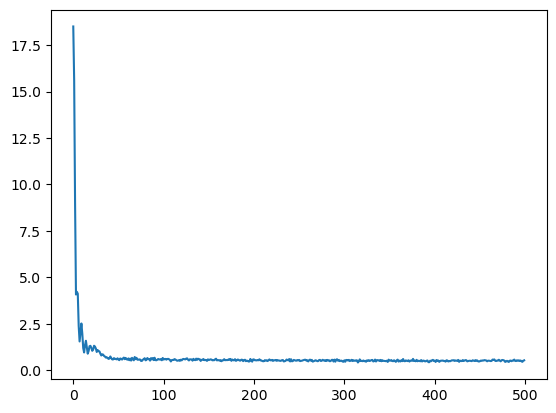

In [6]:
plt.plot(loss_list)

## References

[1] [深度学习求解微分方程系列二：PINN求解burger方程](https://zhuanlan.zhihu.com/p/580523274)
[2] [浅析Burgers 方程](https://zhuanlan.zhihu.com/p/339649042)